## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [9]:
! pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 2.6MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 8.3MB/s ta 0:00:01
Requirement not upgraded as not directly required: six>=1.10 in /home/cedric/anaconda3/lib/python3.7/site-packages (from kaggle) (1.11.0)
Requirement not upgraded as not directly required: certifi in /home/cedric/anaconda3/lib/python3.7/site-packages (from kaggle) (2018.8.24)
Requirement not upgraded as not directly required: python-dateutil in /home/cedric/anaconda3/lib/python3.7/site-packages (from kaggle) (2.7.3)
Requirement not upgraded as not directly required: requests in /home/cedric/anaconda3/lib/python3.7/site-packages (from kaggle) (2.19.1)
Requirement not upgraded as not directly required: tqdm in /home/cedric/anaconda3/lib/python3.7/site-packages (from kaggle) (4.26.0)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /home/cedric/anaconda3/lib/python3.7/site-packages (from requests->kaggle) (3.0.4)
Requirement no

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [16]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [3]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/cedric/.fastai/data/planet')

In [23]:
! kaggle --version

Kaggle API 1.5.1.1


In [24]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}

100%|█████████████████████████████████████████| 600M/600M [00:04<00:00, 140MB/s]

  0%|                                                | 0.00/159k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 70.7MB/s]


In [27]:
! unzip -q -n {path}/train_v2.csv.zip -d {path}

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [28]:
! conda install -y -c haasad eidl7zip

Solving environment: done

## Package Plan ##

  environment location: /home/cedric/anaconda3

  added / updated specs: 
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    eidl7zip-1.0.0             |                1         565 KB  haasad

The following NEW packages will be INSTALLED:

    eidl7zip: 1.0.0-1          haasad

The following packages will be UPDATED:

    certifi:  2018.8.24-py37_1        --> 2018.10.15-py37_0


eidl7zip-1.0.0       | 565 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [34]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [37]:
!ls {path}/train-jpg | head -n10

train_0.jpg
train_1.jpg
train_10.jpg
train_100.jpg
train_1000.jpg
train_10000.jpg
train_10001.jpg
train_10002.jpg
train_10003.jpg
train_10004.jpg
ls: write error: Broken pipe


## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [4]:
# This is a set of transformation which is pretty good for satellite images
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [7]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

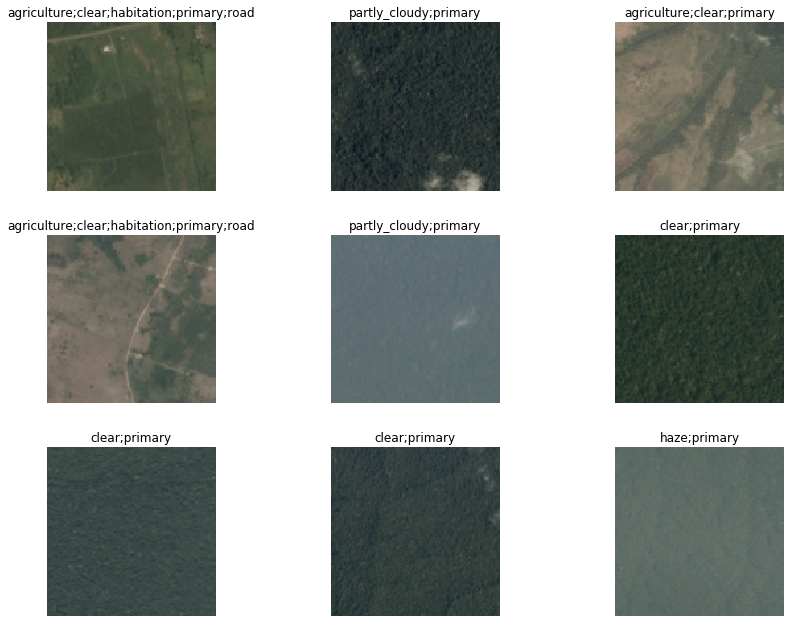

In [55]:
data.show_batch(rows=3, figsize=(12,9))

### Initial Model

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50, but the metrics are a little bit different: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [5]:
arch = models.resnet50

In [6]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [9]:
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


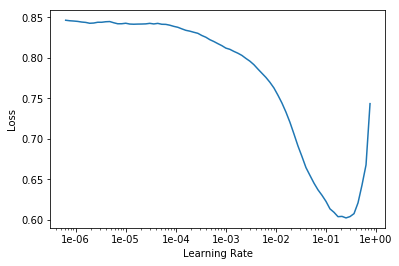

In [61]:
learn.recorder.plot()

Then we can fit the head of our network.

In [10]:
lr = 0.01

In [67]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.125452,0.108757,0.946554,0.904610
2,0.107338,0.098813,0.955012,0.915407
3,0.102584,0.091885,0.951488,0.918018
4,0.094727,0.088227,0.955921,0.924755
5,0.094570,0.087069,0.957345,0.924986


In [68]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [11]:
learn.unfreeze()

In [70]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


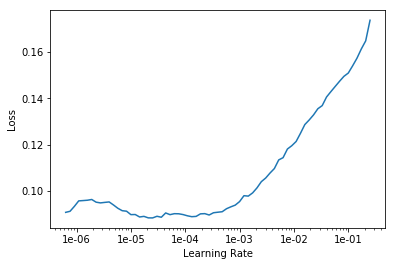

In [71]:
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.095748,0.092037,0.953370,0.918665
2,0.097214,0.089237,0.954547,0.923939
3,0.093682,0.085165,0.957773,0.926799
4,0.082624,0.083528,0.958755,0.928822
5,0.081399,0.082552,0.958820,0.929817


In [73]:
learn.save('stage-2-rn50')

In [12]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: /home/cedric/.fastai/data/planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/cedric/.fastai/data/planet;

Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: /home/cedric/.fastai/data/planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/cedric/.fastai/data/pla

### Use Full Size Images

We've used the image size of 128px in the initial model. That's simply because we want to try it out very quickly.

Now, let's try to use the full size images.

In [11]:
data = (src.transform(tfms, size=256)
        .databunch(bs=32).normalize(imagenet_stats))

In [12]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [13]:
learn.freeze()

Notice that we are using **transfer learning**. Instead of training from the beginning, we just start from model we trained with smaller images.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


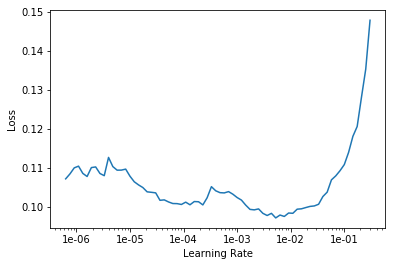

In [30]:
learn.lr_find()
learn.recorder.plot()

**Training Stage 1 - Freeze**

In [35]:
lr = 1e-3/2

In [40]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.094077,0.087534,0.955986,0.924598
2,0.091243,0.084497,0.958427,0.928731
3,0.087307,0.084192,0.959721,0.929067
4,0.085676,0.083820,0.959140,0.929437
5,0.084220,0.083667,0.959351,0.929003


In [41]:
learn.save('stage-1-256-rn50')

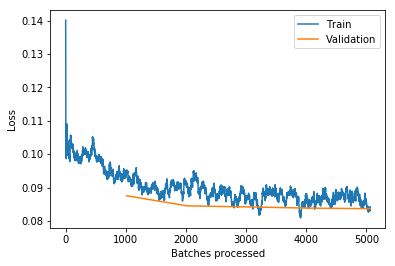

In [45]:
learn.recorder.plot_losses()

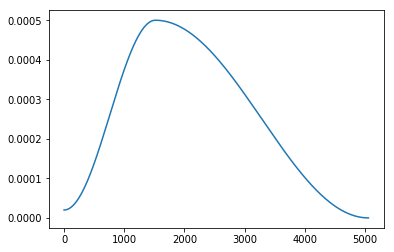

In [46]:
learn.recorder.plot_lr()

**Training Stage 2 - Unfreeze**

In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


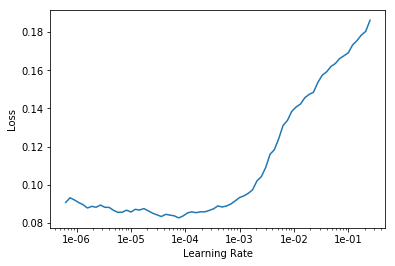

In [48]:
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.089080,0.082964,0.959583,0.929218
2,0.084257,0.083247,0.960295,0.929339
3,0.083025,0.081792,0.959714,0.929984
4,0.082981,0.081631,0.959692,0.930018
5,0.077415,0.081828,0.960324,0.929595


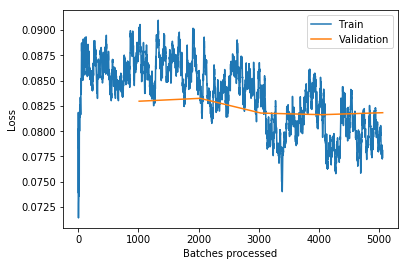

In [60]:
learn.recorder.plot_losses()

In [61]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99%|███████████████████████████████████████▋| 599M/603M [00:11<00:00, 88.6MB/s]
100%|████████████████████████████████████████| 603M/603M [00:11<00:00, 53.2MB/s]


In [15]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: /home/cedric/.fastai/data/planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/cedric/.fastai/data/planet;

Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: /home/cedric/.fastai/data/planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/cedric/.fastai/data/pla

## Test

### Download test dataset

Use Kaggle API to download the test dataset:

In [63]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}

 99%|████████████████████████████████████████▋| 598M/603M [00:04<00:00, 131MB/s]
100%|█████████████████████████████████████████| 603M/603M [00:04<00:00, 142MB/s]
 98%|████████████████████████████████████████ | 297M/304M [00:02<00:00, 110MB/s]
100%|█████████████████████████████████████████| 304M/304M [00:02<00:00, 115MB/s]


In [64]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [65]:
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [68]:
! mv {path}/test-jpg-additional/* {path}/test-jpg

In [72]:
! ls {path}/test-jpg | wc -l

61191


In [73]:
! rm -rf {path}/test-jpg-additional

### Add test data to ImageItemList and ImageDataBunch

In [17]:
type(src)

fastai.data_block.LabelLists

In [18]:
learn.data =(src.add_test_folder('test-jpg')
             .transform(tfms, size=256)
             .databunch(bs=8).normalize(imagenet_stats))

In [19]:
# Sanity check
len(learn.data.train_ds), len(learn.data.valid_ds), len(learn.data.test_ds)

(32384, 8095, 61191)

In [20]:
# Sanity check
len(learn.data.train_dl), len(learn.data.valid_dl), len(learn.data.test_dl)

(4048, 1012, 7649)

In [21]:
# Sanity check
learn.data.test_ds

LabelList
y: MultiCategoryList (61191 items)
[MultiCategory haze;primary, MultiCategory haze;primary, MultiCategory haze;primary, MultiCategory haze;primary, MultiCategory haze;primary]...
Path: /home/cedric/.fastai/data/planet
x: ImageItemList (61191 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/cedric/.fastai/data/planet

### Kaggle Submission

Applies fastai Test-Time-Augmentation ([TTA](https://docs.fast.ai/tta.html)) to predict on test set:

In [23]:
preds = learn.TTA(ds_type=DatasetType.Test) # TTA brings test time functionality to the Learner class.

In [94]:
torch.save(preds, path/'preds-tta-256-rn50.pt')

Get final predictions:

In [34]:
final_preds = preds[0] # note, preds[1] is y, which is the ground truth/target
final_preds.shape

torch.Size([61191, 17])

In [47]:
# Sanity check
len(final_preds[1])

17

In [43]:
# Sanity check
final_preds[0][0]

tensor(0.8172)

In [84]:
# PS: I have taken these parts of code from Arunoda's notebook.

def find_tags(pred, thresh, show_probs):
    classes = ''
    for idx, val in enumerate(pred):
        if val > thresh:
            if show_probs == True:
                classes = f'{classes} {learn.data.classes[idx]} ({val})'
            else:
                classes = f'{classes} {learn.data.classes[idx]}'
    return classes.strip()

def predict(f_preds, idx, thresh):
    pred_vals = f_preds[idx]
    tags = find_tags(pred_vals, thresh, True)
    print(tags)
    img = learn.data.test_ds[idx][0]
    return img

agriculture (0.8172218799591064) haze (0.4136252701282501) partly_cloudy (0.37629154324531555) primary (0.9813070297241211)


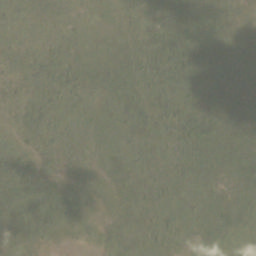

In [85]:
predict(final_preds, 0,  0.2)

cloudy (0.3825205862522125) haze (0.5826690196990967) primary (0.6680986285209656)


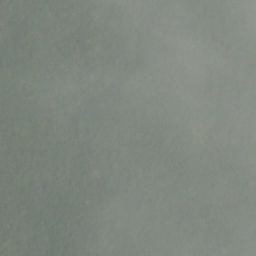

In [86]:
predict(final_preds, 20,  0.2)

In [87]:
def get_row(f_preds, idx, thresh):
    pred = f_preds[idx]
    tags = find_tags(pred, thresh, False)
    image_path = learn.data.test_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    
    return image_name, tags

In [88]:
get_row(final_preds, 0, 0.2)

('file_19658', 'agriculture haze partly_cloudy primary')

In [89]:
get_row(final_preds, 20, 0.2)

('test_18218', 'cloudy haze primary')

Create data frame for Kaggle submission file:

In [90]:
df = pd.DataFrame(columns=['image_name', 'tags'])

for idx in range(len(final_preds)):
    if idx % 1000 == 0:
        print(f'Progress: {idx}')

    image_name, tags = get_row(final_preds, idx, 0.2)
    df.loc[idx] = [image_name, tags]

Progress: 0
Progress: 1000
Progress: 2000
Progress: 3000
Progress: 4000
Progress: 5000
Progress: 6000
Progress: 7000
Progress: 8000
Progress: 9000
Progress: 10000
Progress: 11000
Progress: 12000
Progress: 13000
Progress: 14000
Progress: 15000
Progress: 16000
Progress: 17000
Progress: 18000
Progress: 19000
Progress: 20000
Progress: 21000
Progress: 22000
Progress: 23000
Progress: 24000
Progress: 25000
Progress: 26000
Progress: 27000
Progress: 28000
Progress: 29000
Progress: 30000
Progress: 31000
Progress: 32000
Progress: 33000
Progress: 34000
Progress: 35000
Progress: 36000
Progress: 37000
Progress: 38000
Progress: 39000
Progress: 40000
Progress: 41000
Progress: 42000
Progress: 43000
Progress: 44000
Progress: 45000
Progress: 46000
Progress: 47000
Progress: 48000
Progress: 49000
Progress: 50000
Progress: 51000
Progress: 52000
Progress: 53000
Progress: 54000
Progress: 55000
Progress: 56000
Progress: 57000
Progress: 58000
Progress: 59000
Progress: 60000
Progress: 61000


In [91]:
df.head()

,filename,tags
0,file_19658,agriculture haze partly_cloudy primary
1,test_18775,agriculture bare_ground clear habitation prima...
2,file_20453,agriculture haze primary
3,test_23183,clear primary water
4,test_28867,partly_cloudy primary


In [95]:
subm_path = path/'subm_fastai_1.0.34_tta_stage2_sz_256_rn50_val_0.2.csv'
df.to_csv(subm_path, index=False)

In [98]:
# Sanity check
! head {subm_path}

image_name,tags
file_19658,agriculture haze partly_cloudy primary
test_18775,agriculture bare_ground clear habitation primary road
file_20453,agriculture haze primary
test_23183,clear primary water
test_28867,partly_cloudy primary
test_17746,clear primary
test_11747,agriculture clear primary water
test_21382,clear primary
test_10914,agriculture clear haze primary road water


**Upload submission file to Kaggle**

Kaggle allows late submission to check your score. You can use the following command to do that:

In [99]:
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {subm_path} -m "fastai: 1.0.34, train: stage2, sz: 256, arch: resnet50, val split: 0.2, TTA"

100%|██████████████████████████████████████| 2.19M/2.19M [00:00<00:00, 7.36MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

---

![](https://i.imgur.com/H560plJ.png)